In [1]:
import spacy
import timeit
import math
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from collections import Counter
from lxml import etree
from glob import glob
from unicodedata import normalize
from tqdm import tqdm
import numpy as np
from sklearn import set_config
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import unidecode
import prince

In [2]:
nlp = spacy.load('fr_core_news_lg')

## Get features to extract

In [4]:
def clean_text(txt):
    txt_res = normalize("NFKD", str(txt).replace(u'\xa0', u' '))
    txt_res = txt_res.replace(u'\\xa0', u' ')
    txt_res = txt_res.replace(u'\\n', u'')
    txt_res = txt_res.replace(u'\n', u'')
    txt_res = txt_res.replace(u'\\', u'')
    txt_res = txt_res.replace(u'\'', u'')

    return txt_res

In [5]:
def get_n_most_common_features(list_tokens, n):
    table_freq = dict(Counter(list_tokens).most_common(n))
    return list(table_freq.keys())

In [6]:
def bigrammize(list_token):
    """fonction qui prend en parametre une liste de tokens et retourne une liste de bi-grammes"""
    list_bigram = []
    for indice_token in range(len(list_token)-1):
        bigram = list_token[indice_token]+'_'+list_token[indice_token+1]
        list_bigram.append(bigram)
    return list_bigram

In [7]:
def trigrammize(list_token):
    """fonction qui prend en parametre une liste de tokens et retourne une liste de tri-grammes"""
    list_trigram = []
    for indice_token in range(len(list_token)-2):
        trigram = list_token[indice_token]+'_'+list_token[indice_token+1]+'_'+list_token[indice_token+2]
        list_trigram.append(trigram)
    return list_trigram

In [8]:
def get_n_features(path_name, n):
    str_base = " "
    list_illitch = []
    for doc in glob(path_name):
        list_lemma, list_token, nombre_tokens = pipeline_spacy(doc)
        print(doc +' : '+str(nombre_tokens)+' tokens')
        list_bigram_lemma = bigrammize(list_lemma)
        list_trigram_lemma = trigrammize(list_lemma)
        
        list_bigram_token = bigrammize(list_token)
        list_trigram_token = trigrammize(list_token)
        
        
        list_lemma_result = get_n_most_common_features(list_lemma, n)
        list_bigram_lemma_result = get_n_most_common_features(list_bigram_lemma, n)
        list_trigram_lemma_result = get_n_most_common_features(list_trigram_lemma, n)
    
        list_token_result = get_n_most_common_features(list_token, n)
        list_bigram_token_result = get_n_most_common_features(list_bigram_token, n)
        list_trigram_token_result = get_n_most_common_features(list_trigram_token, n)

    return list_lemma_result, list_bigram_lemma_result, list_trigram_lemma_result, list_token_result, list_bigram_token_result, list_trigram_token_result

In [9]:
def chunkise(list_token, n):
    list_chunks = []
    for i in range(0, len(list_token)-n, n):
        list_chunks.append(list_token[i:i+n])
    return list_chunks

In [10]:
def pipeline_spacy(path):
    pos_ko = ["NUM", "X", "SYM", "PUNCT", "SPACE"]
    str_base = " "
    list_lemma = []
    list_token = []
    nombre_tokens = 0
    with open(path, encoding="utf8") as file:
        text_ivan = file.readlines()
        text_ivan_str = str_base.join(text_ivan)
        text_ivan_cleaned = clean_text(text_ivan_str.lower())

        docs = nlp(text_ivan_cleaned)
        nombre_tokens += len(docs)
        
        for token in docs:
            if token.pos_ not in pos_ko:
                list_lemma.append(token.lemma_)
                list_token.append(token.text)

    return list_lemma, list_token, nombre_tokens

In [11]:
n_most_common_features = 500

In [12]:
path_name = "data/Tolstoi - La mort de Ivan Ilitch.txt"

In [13]:
list_lemma_result, list_bigram_lemma_result, list_trigram_lemma_result, list_token_result, list_bigram_token_result, list_trigram_token_result = get_n_features(path_name, n_most_common_features)

data/Tolstoi - La mort de Ivan Ilitch.txt : 25885 tokens


## Get Features

In [14]:
def dict_freq_token(list_lemma, list_select):
    
    dict_result = dict.fromkeys(list_select)
    
    dict_temp = Counter(list_lemma)
        
    for key in dict_temp.keys():
        if key in dict_result.keys():
            dict_result[key] = dict_temp[key]/len(list_lemma)
    
    return dict_result

In [15]:
def compute_list(list_selected, list_chunks_tokens, doc_name):
    
    df_lemma = pd.DataFrame()
    dict_chunks = {}
    i=1
    
    for chunk in list_chunks_tokens:
                
        dict_chunk = dict_freq_token(chunk, list_selected)
        dict_chunk["index"] = doc_name+'_chunk_'+str(i)

        #update ici pour les autres features
        
        df_temp_lemma = pd.DataFrame(dict_chunk, index=[0])
        
        df_lemma = df_lemma.append(df_temp_lemma, ignore_index = True)
        
        i+=1
    return df_lemma

In [16]:
def mouli_ivan(path_name, n, list_lemma_select, list_bigram_select):
    
    str_base = " "
    list_illitch = []
    
    dict_results_lemma = {}
    
    df_lemma = pd.DataFrame()
    
    for doc in glob(path_name):
        
        doc_name = path.splitext(path.basename(doc))[0]
        
        list_lemma_temp, list_token_temp, nombre_tokens = pipeline_spacy(doc)
        print(doc +' : '+str(nombre_tokens)+' tokens')
        
        list_bigram_lemma_temp = bigrammize(list_lemma_temp)
        

        list_chunks_lemma = chunkise(list_lemma_temp, n)
        list_chunks_bigram_lemma = chunkise(list_bigram_lemma_temp, n)

        
        df_lemma_temp = compute_bigram_list(list_lemma_select, list_chunks_lemma, list_bigram_select, list_chunks_bigram_lemma, doc_name)
        
        df_lemma = df_lemma.append(df_lemma_temp, ignore_index = True)

    df_lemma.set_index("index", inplace = True)
        
    return df_lemma

In [17]:
def compute_bigram_list(list_selected, list_chunks_tokens, list_bigram_selected, list_chunks_bigram_tokens, doc_name):
    
    df_lemma = pd.DataFrame()
    dict_chunks = {}
    j=1
    
    for i in range(len(list_chunks_tokens)):
        chunk = list_chunks_tokens[i]
        chunk_bigrams = list_chunks_bigram_tokens[i]
        
        dict_chunk = dict_freq_token(chunk, list_selected)
        dict_chunk.update(dict_freq_token(chunk_bigrams, list_bigram_selected))

        dict_chunk["index"] = doc_name+'_chunk_'+str(j)

        #update ici pour les autres features
        
        df_temp_lemma = pd.DataFrame(dict_chunk, index=[0])
        
        df_lemma = df_lemma.append(df_temp_lemma, ignore_index = True)
        
        j+=1
    return df_lemma

In [192]:
n_token_per_chunk = 100

In [193]:
path_name = r'data/chapitres_II/*.txt'

In [194]:
df_lemma_ivan = mouli_ivan(path_name, n_token_per_chunk, list_lemma_result, list_bigram_lemma_result)

data/chapitres_II/chap_10.txt : 965 tokens
data/chapitres_II/chap_03.txt : 3155 tokens
data/chapitres_II/chap_09.txt : 1213 tokens
data/chapitres_II/chap_04.txt : 3186 tokens
data/chapitres_II/chap_02.txt : 3314 tokens
data/chapitres_II/chap_12.txt : 996 tokens
data/chapitres_II/chap_07.txt : 1897 tokens
data/chapitres_II/chap_11.txt : 1170 tokens
data/chapitres_II/chap_08.txt : 2962 tokens
data/chapitres_II/chap_05.txt : 1919 tokens
data/chapitres_II/chap_06.txt : 1375 tokens
data/chapitres_II/chap_01.txt : 3698 tokens


In [21]:
def get_chap(index):
    list_chapitre = []
    str_base = '_'
    for elem in index:
        chap = elem.split("_")[0:2]
        list_chapitre.append(str_base.join(chap))
    return list_chapitre

In [86]:
def svm_ivan(data, test_size=0.2, sampling=None, cross_validation=False, cv=5, kernel='rbf', nb_coef=20):
    
    df_results = pd.DataFrame()

    if cross_validation == True:
        pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
        cv_results = cross_validate(pipe, data.drop(['chapitre'], axis=1), data['chapitre'], cv=cv)
        return pipe, cv_results
    
    else:
        pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
    

        X_train, X_test, y_train, y_test = train_test_split(data.drop(['chapitre'], axis=1), data['chapitre'], test_size=test_size, shuffle=True)
        print('Original dataset shape {}'.format(Counter(y_train)))
                

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        
        print(metrics.classification_report(y_test, preds))
        
        print(y_test)
        #cm = confusion_matrix(y_test, preds, labels=['chap_01', 'chap_02', 'chap_03', 'chap_04', 'chap_05', 'chap_06', 'chap_07', 'chap_08'])
        #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['chap_01', 'chap_02', 'chap_03', 'chap_04', 'chap_05', 'chap_06', 'chap_07', 'chap_08'])
        
        
        ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, xticks_rotation='vertical')
        
        #disp.xticks(rotation=60)
        #disp.plot()
        
        if kernel == 'linear':
            coefs = pipe.named_steps['svc'].coef_
            return pipe, coefs

    return pipe


In [195]:
list_chapitre = get_chap(df_lemma_ivan.index)
df_lemma_ivan['chapitre']=list_chapitre
df_lemma_ivan = df_lemma_ivan.replace(np.nan, 0)

Original dataset shape Counter({'chap_01': 22, 'chap_03': 22, 'chap_02': 22, 'chap_04': 21, 'chap_08': 19, 'chap_07': 15, 'chap_05': 10, 'chap_06': 10, 'chap_11': 9, 'chap_09': 7, 'chap_12': 7, 'chap_10': 6})
              precision    recall  f1-score   support

     chap_01       0.55      0.75      0.63         8
     chap_02       0.50      0.71      0.59         7
     chap_03       0.29      0.40      0.33         5
     chap_04       0.29      0.33      0.31         6
     chap_05       1.00      0.60      0.75         5
     chap_06       0.00      0.00      0.00         1
     chap_07       0.00      0.00      0.00         1
     chap_08       0.40      0.40      0.40         5
     chap_09       0.00      0.00      0.00         2
     chap_10       0.00      0.00      0.00         2
     chap_12       0.00      0.00      0.00         1

    accuracy                           0.47        43
   macro avg       0.27      0.29      0.27        43
weighted avg       0.42      0.47

/home/humanum/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/humanum/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/humanum/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


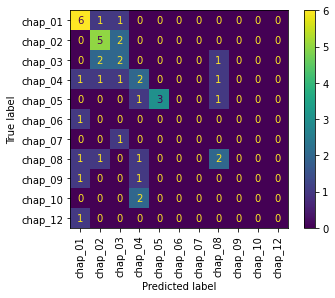

In [197]:
pipe_test, coefs = svm_ivan(df_lemma_ivan, kernel='linear')

In [115]:
def merge_chapitres(list_chap):
    list_res = []
    for chap in list_chap:
        if chap == 'chap_01' or chap == 'chap_04':
            list_res.append('chap_01_04')
        elif chap == 'chap_02' or chap == 'chap_03':
            list_res.append('chap_02_03')        
        elif chap == 'chap_05' or chap == 'chap_06':
            list_res.append('chap_05_06')
        elif chap == 'chap_07' or chap == 'chap_08':
            list_res.append('chap_07_08')
        elif chap == 'chap_09' or chap == 'chap_10' or chap == 'chap_11' or chap == 'chap_12':
            list_res.append('chap_09_10_11_12')
        else:
            print('ERROR : NO CHAPTER MERGEABLE FOUND')
    return list_res

In [131]:
df_lemma_ivan['chapitre'] = merge_chapitres(df_lemma_ivan['chapitre'])

In [198]:
# RERUN NOTEBOOK from n_token_per_chunk = 200 TO GET FOLLOWING RESULTS : 
# (With n_token_per_chunk = 100 - Performances are quite bad)

Original dataset shape Counter({'chap_01_04': 22, 'chap_02_03': 21, 'chap_07_08': 14, 'chap_09_10_11_12': 14, 'chap_05_06': 11})
                  precision    recall  f1-score   support

      chap_01_04       0.71      0.83      0.77         6
      chap_02_03       0.86      1.00      0.92         6
      chap_05_06       0.50      1.00      0.67         1
      chap_07_08       1.00      0.50      0.67         6
chap_09_10_11_12       0.50      0.50      0.50         2

        accuracy                           0.76        21
       macro avg       0.71      0.77      0.71        21
    weighted avg       0.81      0.76      0.75        21

index
chap_03_chunk_8           chap_02_03
chap_03_chunk_4           chap_02_03
chap_03_chunk_10          chap_02_03
chap_04_chunk_2           chap_01_04
chap_03_chunk_13          chap_02_03
chap_01_chunk_5           chap_01_04
chap_08_chunk_7           chap_07_08
chap_09_chunk_1     chap_09_10_11_12
chap_05_chunk_7           chap_05_06
chap_01

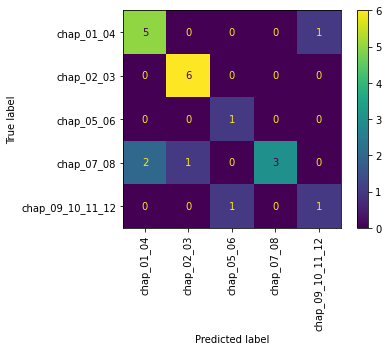

In [140]:
pipe_test, coefs = svm_ivan(df_lemma_ivan, kernel='linear')

In [64]:
df_lemma_ivan.chapitre.value_counts()

chap_01_04          57
chap_02_03          56
chap_07_08          40
chap_09_10_11_12    34
chap_05_06          26
Name: chapitre, dtype: int64

In [77]:
len(coefs[0])

1000

In [78]:
list_features = list(df_lemma_ivan.columns)

In [79]:
list_features = list_features[:1000]

In [175]:
# Resolve issues with french accent :
list_features = [unidecode.unidecode(token) for token in list_features]

In [68]:
#pipe_test.classes_

array(['chap_01_04', 'chap_02_03', 'chap_05_06', 'chap_07_08',
       'chap_09_10_11_12'], dtype=object)

In [ ]:
#coefs[0], coefs[4], coefs[5], coefs[6]

In [ ]:
# len(coef) = 10 because 5 classes => 1vs2, 1vs3, 1vs4, 1vs5, 2vs3, 2vs4, 2vs5, 3vs4, 3vs5, 4vs5

In [227]:
def get_df_coef(coefs, list_features):
    for i in range(0, len(coefs)):
        if i == 0 :
            dict_coef_1 = dict(zip(list_features, coefs[i]))#+ = chap 14 , - = chap23
        if i == 4:
            dict_coef_2 = dict(zip(list_features, coefs[i]))#+ = chap 23 , - = chap56
        if i == 5:
            dict_coef_3 = dict(zip(list_features, coefs[i]))#+ = chap 23 , - = chap78            
        if i == 8:
            dict_coef_4 = dict(zip(list_features, coefs[i]))#+ = chap 56 , - = chap9101112            
            
    return dict_coef_1, dict_coef_2, dict_coef_3, dict_coef_4
            

In [228]:
dict_coef_1, dict_coef_2, dict_coef_3, dict_coef_4 = get_df_coef(coefs, list_features)

## Get Nuage de Mots from COEFS

In [144]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [177]:
wcc = WordCloud(background_color='white', width = 500, height=300, margin=2)

### COEF 1 (chap 1_4)

In [178]:
wcc.fit_words(dict_coef_1)

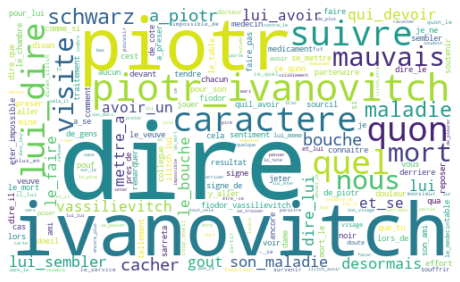

In [179]:
plt.figure(figsize=(8, 8))
plt.imshow(wcc, interpolation='bilinear')
plt.axis("off")
plt.show()

### COEF 2 (chap 2_3)

In [180]:
chap_2_3 = dict((k, v*-1) for k, v in dict_coef_1.items() if v < 0)

In [181]:
wcc.fit_words(chap_2_3)

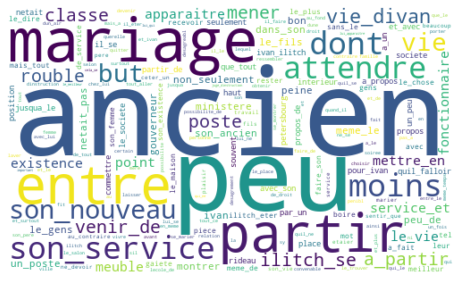

In [182]:
plt.figure(figsize=(8, 8))
plt.imshow(wcc, interpolation='bilinear')
plt.axis("off")
plt.show()

### COEF 3 (chap 5_6)

In [183]:
chap_5_6 = dict((k, v*-1) for k, v in dict_coef_2.items() if v < 0)

In [184]:
wcc.fit_words(chap_5_6)

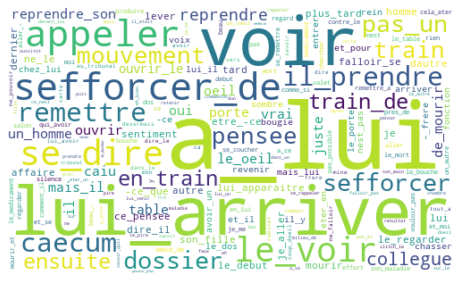

In [185]:
plt.figure(figsize=(8, 8))
plt.imshow(wcc, interpolation='bilinear')
plt.axis("off")
plt.show()

### COEF 4 (chap 7_8)

In [186]:
chap_7_8 = dict((k, v*-1) for k, v in dict_coef_3.items() if v < 0)

In [187]:
wcc.fit_words(chap_7_8)

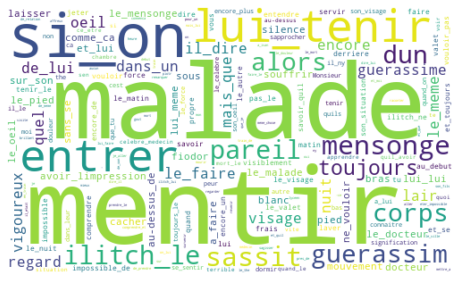

In [188]:
plt.figure(figsize=(8, 8))
plt.imshow(wcc, interpolation='bilinear')
plt.axis("off")
plt.show()

### COEF 5 (chap 9_10_11_12)

In [229]:
chap_9_10_11_12 = dict((k, v*-1) for k, v in dict_coef_4.items() if v < 0)

In [232]:
wcc.fit_words(chap_9_10_11_12)

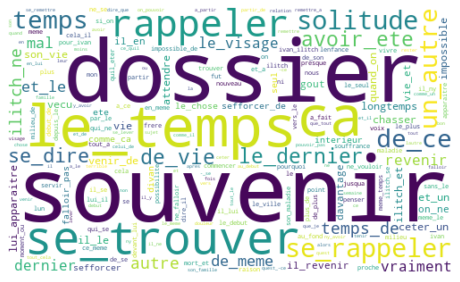

In [233]:
plt.figure(figsize=(8, 8))
plt.imshow(wcc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Discussion :   (EDIT - Out of date --> DONE)

- get more features -> test at least 200 bigrams -> extend n features (only mots outils)
- merge labels chapitres from qualitative insights
- merge labels chapitres from quantitative insights -> Topic Modeling
- matrice de confusion

### Mouli without chunks

In [245]:
def mouli_ivan_sans_chunks(path_name, list_lemma_select, list_bigram_select):
    
    str_base = " "
    list_illitch = []
    
    dict_results_lemma = {}
    
    df_lemma = pd.DataFrame()
    
    for doc in glob(path_name):
        
        doc_name = path.splitext(path.basename(doc))[0]
        
        list_lemma_temp, list_token_temp, nombre_tokens = pipeline_spacy(doc)
        print(doc +' : '+str(nombre_tokens)+' tokens')
        
        list_bigram_lemma_temp = bigrammize(list_lemma_temp)

        df_lemma_temp = compute_bigram_list_sans_chunks(list_lemma_select, list_lemma_temp, list_bigram_select, list_bigram_lemma_temp, doc_name)
        df_lemma = df_lemma.append(df_lemma_temp, ignore_index = True)
        
    df_lemma.set_index("index", inplace = True)
        
    return df_lemma

In [244]:
def compute_bigram_list_sans_chunks(list_selected, list_lemma_temp, list_bigram_selected, list_bigram_lemma_temp, doc_name):
    
    df_lemma = pd.DataFrame()
    dict_chunks = {}
   
    dict_chunk = dict_freq_token(list_lemma_temp, list_selected)
    dict_chunk.update(dict_freq_token(list_bigram_lemma_temp, list_bigram_selected))

    dict_chunk["index"] = doc_name

        #update ici pour les autres features
        
    df_lemma = pd.DataFrame(dict_chunk, index=[0])
                
    return df_lemma

In [246]:
df_lemma_ivan_sans_chunks = mouli_ivan_sans_chunks(path_name, list_lemma_result, list_bigram_lemma_result)

data/chapitres_II/chap_10.txt : 965 tokens
data/chapitres_II/chap_03.txt : 3155 tokens
data/chapitres_II/chap_09.txt : 1213 tokens
data/chapitres_II/chap_04.txt : 3186 tokens
data/chapitres_II/chap_02.txt : 3314 tokens
data/chapitres_II/chap_12.txt : 996 tokens
data/chapitres_II/chap_07.txt : 1897 tokens
data/chapitres_II/chap_11.txt : 1170 tokens
data/chapitres_II/chap_08.txt : 2962 tokens
data/chapitres_II/chap_05.txt : 1919 tokens
data/chapitres_II/chap_06.txt : 1375 tokens
data/chapitres_II/chap_01.txt : 3698 tokens


In [247]:
df_lemma_ivan_sans_chunks

,le,de,et,il,son,un,à,lui,se,ce,...,comme_ça,éter_impossible,avoir_limpression,faire_pas,avoir_dû,le_pire,même_chose,falloir_pas,je_aller,comprendre_et
index,,,,,,,,,,,,,,,,,,,,,
chap_10,0.070732,0.070732,0.035366,0.026829,0.029268,0.013415,0.014634,0.007317,0.020732,0.019512,...,0.001221,0.001221,None,None,None,None,None,0.001221,None,None
chap_03,0.065538,0.058910,0.031664,0.025773,0.020619,0.027614,0.022828,0.011414,0.012518,0.012150,...,None,None,None,None,None,None,None,None,None,None
chap_09,0.053224,0.042989,0.035824,0.044012,0.021494,0.013306,0.012282,0.015353,0.017400,0.010235,...,None,None,None,None,None,None,0.001025,None,None,None
chap_04,0.057860,0.040757,0.032751,0.026201,0.027656,0.021834,0.018923,0.021106,0.017103,0.018195,...,0.000364,0.000728,0.000364,0.000728,0.000364,0.000728,0.000364,0.000364,0.000364,0.000728
chap_02,0.062457,0.057310,0.037062,0.024365,0.031915,0.022649,0.024365,0.009266,0.012011,0.008922,...,None,None,None,None,None,None,None,None,None,None
chap_12,0.061097,0.056110,0.031172,0.054863,0.028678,0.012469,0.024938,0.013716,0.016209,0.026185,...,None,None,None,None,0.001248,None,None,None,None,None
chap_07,0.053416,0.052174,0.031677,0.022981,0.026087,0.017391,0.013665,0.019876,0.012422,0.011801,...,0.001243,0.000622,0.001865,0.000622,None,None,None,None,0.000622,None
chap_11,0.061792,0.032956,0.035015,0.035015,0.042225,0.012358,0.019567,0.028836,0.015448,0.015448,...,None,None,None,0.001031,0.002062,0.001031,None,None,None,None
chap_08,0.073091,0.042875,0.032258,0.026950,0.021641,0.019192,0.018375,0.021641,0.013883,0.009800,...,0.000408,0.000408,0.000408,0.000408,0.000408,0.000408,0.001225,None,0.000408,0.000408


### PCA

In [304]:
df_lemma_ivan

,le,de,et,il,son,un,à,lui,se,ce,...,éter_impossible,avoir_limpression,faire_pas,avoir_dû,le_pire,même_chose,falloir_pas,je_aller,comprendre_et,chapitre
index,,,,,,,,,,,,,,,,,,,,,
chap_10_chunk_0,0.10,0.05,0.04,0.03,0.03,0.00,0.02,0.00,0.01,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,chap_10
chap_10_chunk_1,0.11,0.03,0.07,0.00,0.04,0.00,0.01,0.00,0.01,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,chap_10
chap_10_chunk_2,0.07,0.11,0.01,0.03,0.02,0.02,0.01,0.01,0.03,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,chap_10
chap_10_chunk_3,0.11,0.07,0.03,0.01,0.03,0.01,0.01,0.02,0.01,0.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,chap_10
chap_10_chunk_4,0.05,0.07,0.04,0.02,0.03,0.03,0.01,0.00,0.01,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,chap_10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chap_01_chunk_25,0.04,0.07,0.03,0.02,0.02,0.00,0.06,0.07,0.05,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,chap_01_04
chap_01_chunk_26,0.02,0.03,0.02,0.03,0.04,0.02,0.02,0.03,0.03,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,chap_01_04
chap_01_chunk_27,0.07,0.05,0.03,0.01,0.00,0.05,0.02,0.05,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,chap_01_04


In [319]:
X = df_lemma_ivan.iloc[:, :900]
y = df_lemma_ivan['chapitre']

In [140]:
pca = prince.PCA(
     n_components=2,
     n_iter=3,
     rescale_with_mean=True,
     rescale_with_std=True,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )


In [307]:
pca = pca.fit(X)

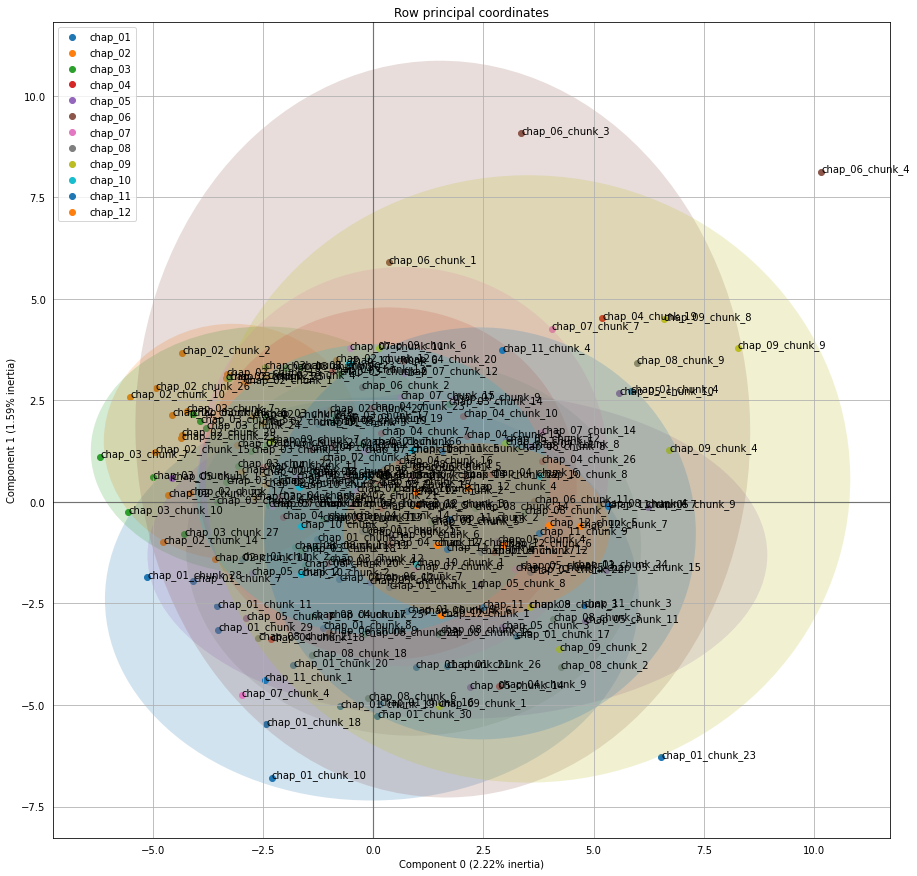

In [142]:
ax = pca.plot_row_coordinates(
     X,
     ax=None,
     figsize=(15, 15),
     x_component=0,
     y_component=1,
     labels=X.index,
     color_labels=y,
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True
     )

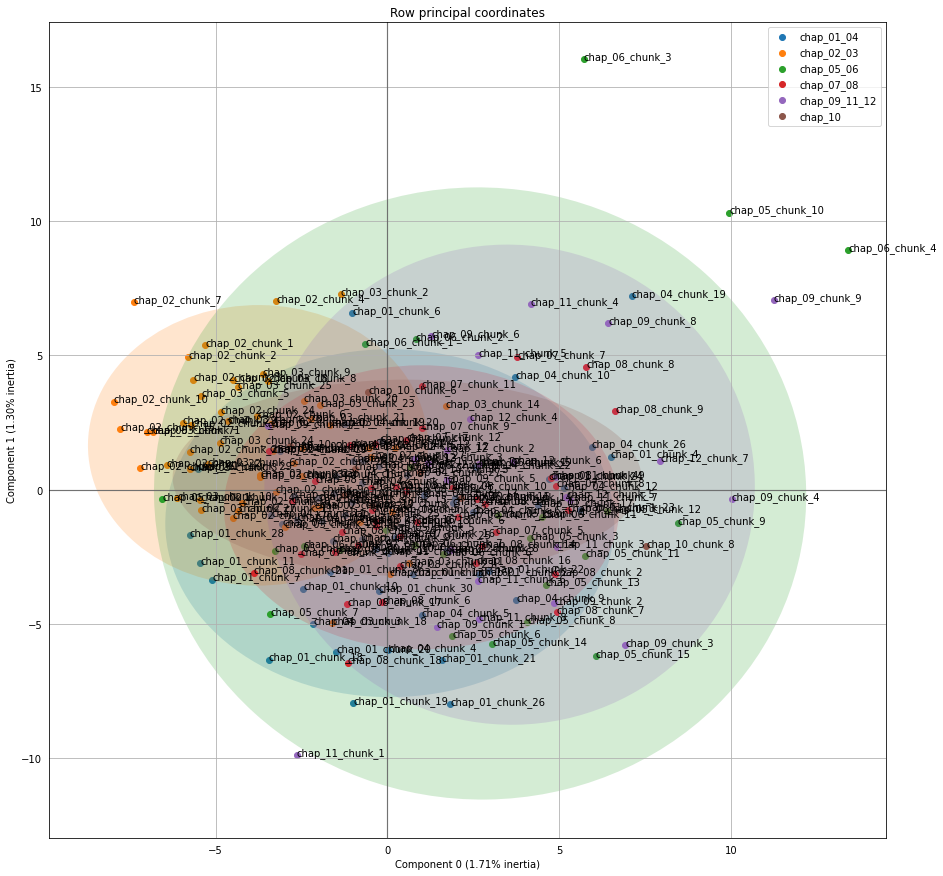

In [320]:
ax = pca.plot_row_coordinates(
     X,
     ax=None,
     figsize=(15, 15),
     x_component=0,
     y_component=1,
     labels=X.index,
     color_labels=y,
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True
     )

In [259]:
list_chapitre = get_chap(df_lemma_ivan_sans_chunks.index)
df_lemma_ivan_sans_chunks['chapitre']=list_chapitre
df_lemma_ivan_sans_chunks = df_lemma_ivan_sans_chunks.replace(np.nan, 0)
df_lemma_ivan_sans_chunks.replace([np.inf, -np.inf], 0, inplace=True)

In [260]:
X = df_lemma_ivan_sans_chunks.iloc[:, :900]
y = df_lemma_ivan_sans_chunks['chapitre']

In [269]:
pca = pca.fit(X)

In [270]:
df_pca = pca.row_coordinates(X)

In [271]:
df_pca.columns = ['new_col1', 'new_col2']

In [272]:
df_pca

,new_col1,new_col2
index,,
chap_10,5.785653,30.470075
chap_03,-16.049075,2.745200
chap_09,15.381039,-1.586422
chap_04,-8.822858,-3.516280
chap_02,-14.249201,8.081912
chap_12,22.718556,1.152526
chap_07,-4.483044,-1.370794
chap_11,10.110066,-9.303849
chap_08,-3.315002,-5.800906


In [282]:
df_pca['chapitre']= list(df_pca.index)


In [283]:
df_pca

,new_col1,new_col2,chapitre
index,,,
chap_10,5.785653,30.470075,chap_10
chap_03,-16.049075,2.745200,chap_03
chap_09,15.381039,-1.586422,chap_09
chap_04,-8.822858,-3.516280,chap_04
chap_02,-14.249201,8.081912,chap_02
chap_12,22.718556,1.152526,chap_12
chap_07,-4.483044,-1.370794,chap_07
chap_11,10.110066,-9.303849,chap_11
chap_08,-3.315002,-5.800906,chap_08


In [279]:
def scatter_text(x, y, text_column, data, title, xlabel, ylabel, hue=None):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, data=data, hue=hue, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.2, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

<AxesSubplot:title={'center':'PCA Ivan Illitch'}, xlabel='Dim 1', ylabel='Dim 2'>

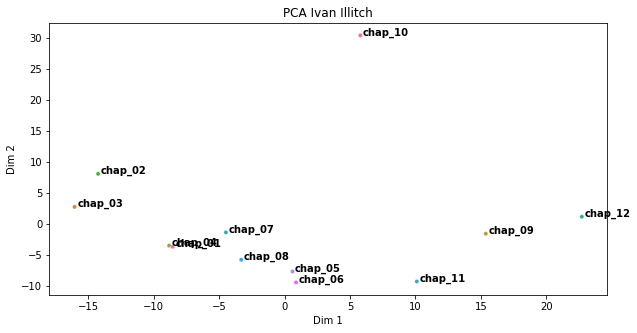

In [286]:
plt.figure(figsize=(10,5))
scatter_text('new_col1', 'new_col2', 'chapitre',
             data = df_pca, 
             title = 'PCA Ivan Illitch', 
             xlabel = 'Dim 1',
             ylabel = 'Dim 2',
            hue='chapitre')

In [203]:
import seaborn as sns

In [211]:
df_longueur = pd.DataFrame(columns=['chapitre', 'longueur'])

In [212]:
df_longueur['chapitre'] = ['chap_01', 'chap_02', 'chap_03', 'chap_04', 'chap_05', 'chap_06', 'chap_07', 'chap_08', 'chap_09', 'chap_10', 'chap_11', 'chap_12']

In [213]:
df_longueur['longeur']=[3698,
3314,
3155,
3186,
1919,
1375,
1897,
2962,
1213,
965,
1170,
996]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

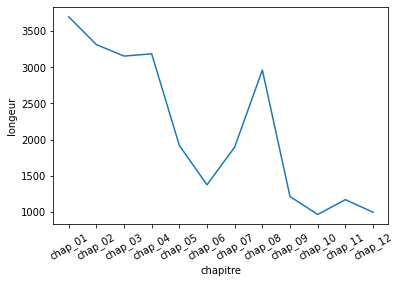

In [219]:
ax = sns.lineplot(data=df_longueur, x="chapitre", y="longeur")
plt.xticks(rotation=30)
